In [1]:
from pandas.core.groupby.groupby import OutputFrameOrSeries
"""
ACMS 80770-03: Deep Learning with Graphs
Instructor: Navid Shervani-Tabar
Fall 2022
University of Notre Dame
Homework 2: Programming assignment
Problem 1
"""
import torch
from torch import nn
from torch import optim
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter(action='ignore', category=UserWarning)
from chainer_chemistry import datasets
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor


"""
    load data
"""
dataset, dataset_smiles = datasets.get_qm9(GGNNPreprocessor(kekulize=True), return_smiles=True,
                                           target_index=np.random.choice(range(133000), 6000, False))

V = 9
atom_types = [6, 8, 7, 9, 1]

def adj(x):
    x = x[1]
    adjacency = np.zeros((V, V)).astype(float)
    adjacency[:len(x[0]), :len(x[0])] = x[0] + 2 * x[1] + 3 * x[2]
    return torch.tensor(adjacency)


def sig(x):
    x = x[0]
    atoms = np.ones((V)).astype(float)
    atoms[:len(x)] = x
    out = np.array([int(atom == atom_type) for atom_type in atom_types for atom in atoms]).astype(float)
    return torch.tensor(out).reshape(5, len(atoms)).T


def target(x):
    x = x[2]
    return torch.tensor(x)


adjs = torch.stack(list(map(adj, dataset))).float()
sigs = torch.stack(list(map(sig, dataset))).float()
prop = torch.stack(list(map(target, dataset)))[:, 5].float()

100%|██████████| 6000/6000 [00:02<00:00, 2732.93it/s]


In [2]:
class GCN:
    """
        Graph convolutional layer
    """
    def __init__(self, in_features, out_features):
        # -- initialize weight
        self.lin = nn.Linear(in_features,out_features)

        # -- non-linearity, here we add relu in model class


    def __call__(self, A, H):
        # -- GCN propagation rule
        # A: batch_size*n*n, H:batch_size*n*5
        # H^{k} = D^{-1/2}*(A+I)*D^{-1/2}*H*W
        # return batch_size*n*3
        n = A.shape[-1]
        D_negative_sqrt = torch.diag_embed(1/(A+torch.eye(n)).sum(dim=2).sqrt())
        H = D_negative_sqrt@(A+torch.eye(n))@D_negative_sqrt@H
        H = self.lin(H)
        return H


class MyModel(nn.Module):
    """
        Regression  model
    """
    def __init__(self):
        super(MyModel, self).__init__()
        # -- initialize layers
        torch.manual_seed(10000)
        self.conv_external   = nn.Linear(5,9) # GCN(5,9)
        self.conv_mu         = nn.Linear(9,2)
        self.conv_log_sigma  = nn.Linear(9,2)
#         self.lin2 = nn.Linear(3,3)

    def forward(self, A, h0):
        n = A.shape[-1]
        D_negative_sqrt = torch.diag_embed(1/(A+torch.eye(n)).sum(dim=2).sqrt())
        A_norm = D_negative_sqrt@(A+torch.eye(n))@D_negative_sqrt


        x = A_norm@h0
        x = self.conv_external(x)


        # output: batch_size*1
        # x = self.conv_external(A,h0)
        x = x.relu()
        
        
        x_mu = A_norm@x
        x_mu = self.conv_mu(x)
        
        x_log_sigma = A_norm@x
        x_log_sigma = self.conv_mu(x_log_sigma)
        
        
        latent_variables = x_mu  + torch.randn(9,2) * x_log_sigma.exp()
        
        n_graphs = latent_variables.shape[0]

        latent_variables_tranpose = torch.transpose(latent_variables,1,2)
        A_hat_reconstructed = latent_variables@latent_variables_tranpose

        A_hat_reconstructed = torch.reshape(A_hat_reconstructed,(n_graphs,-1))

        A_hat_reconstructed = A_hat_reconstructed.sigmoid()

        return A_hat_reconstructed, x_mu, x_log_sigma

In [3]:
norm = adjs.shape[0] * adjs.shape[0] / float((adjs.shape[0] * adjs.shape[0] - adjs.sum()) * 2)
# pos_weight2 = float(adjs.shape[0] * adjs.shape[0] - adjs.sum()) / adjs.sum()


from utils import *

n_graphs = adjs.shape[0]

Adj_hat = Get_AdjHat(adjs)
Adj_hat_reshape = torch.reshape(Adj_hat,(n_graphs,-1))

Adj_hat_reshape.shape

torch.Size([6000, 81])

Text(0, 0.5, 'MSE Loss')

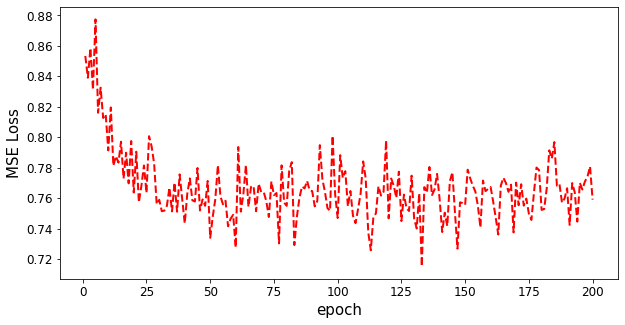

In [4]:
"""
    Train
"""
# -- Initialize the model, loss function, and the optimizer
model = MyModel()
# MyLoss = nn.KLDivLoss()
# MyLoss = nn.MSELoss()
# MyLoss = nn.BCEWithLogitsLoss()
MyLoss = nn.BCELoss()

MyOptimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_epoch = []

n_epochs = 200
batch_size = 100
# -- update parameters
for epoch in range(n_epochs):
    cum_loss = 0
    # 50 iterations needed for 5000 samples
    for i in range(50):

        # -- predict
        MyOptimizer.zero_grad()
        pred, mean, logstd  = model(adjs[i*batch_size:(i+1)*batch_size], sigs[i*batch_size:(i+1)*batch_size])
        labels = Adj_hat_reshape[i*batch_size:(i+1)*batch_size]


        loss = MyLoss(pred, labels)

        # # # -- loss
        # loss = norm*MyLoss(model(adjs[i*batch_size:(i+1)*batch_size], sigs[i*batch_size:(i+1)*batch_size])[0],labels)
        
        # kl_divergence = 0.5/ pred.size(0) * (1 + 2*logstd - mean**2 - torch.exp(logstd)**2).sum(1).mean()
        # loss -= kl_divergence
        
        # -- optimize
        loss.backward()
        MyOptimizer.step()
        
        cum_loss += loss.item()
    
    loss_epoch.append(cum_loss/50)
    


# -- plot loss
X = np.arange(1, n_epochs+1)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X, loss_epoch,'r--', lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('epoch', fontsize=15)
ax.set_ylabel('MSE Loss', fontsize=15)

In [18]:
# evaluate
pred, mean, logstd = model(adjs[5000:], sigs[5000:])
labels = Adj_hat_reshape[5000:]

loss = MyLoss(pred, labels)

print("Loss function value in the validation set = ", np.round(loss.item(), 4))

Loss function value in the validation set =  0.6891
